<a href="https://colab.research.google.com/github/rbuzmaa/MLproject/blob/main/ColonCancer0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!ls /content  # !linux command to list files

kaggle.json  sample_data


In [24]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
 99% 1.75G/1.76G [00:16<00:00, 188MB/s]
100% 1.76G/1.76G [00:16<00:00, 113MB/s]


In [26]:
!unzip -q lung-and-colon-cancer-histopathological-images.zip

replace lung_colon_image_set/colon_image_sets/colon_aca/colonca1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls lung_colon_image_set/colon_image_sets/


ls: cannot access 'lung_colon_image_set/colon_image_sets/': No such file or directory


In [28]:
from torchvision import datasets

dataset = datasets.ImageFolder("lung_colon_image_set/colon_image_sets")

print("Classes", dataset.classes)
print("Total images:", len(dataset))

#from torch.utils.data import DataLoader
#from torchvision.datasets import ImageFolder

Classes ['colon_aca', 'colon_n']
Total images: 10000


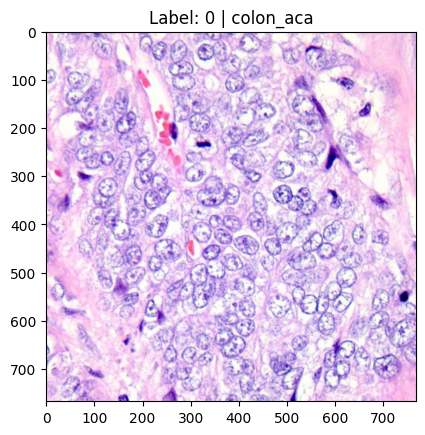

In [29]:
from PIL import Image    # Python imaging library okay next
import matplotlib.pyplot as plt

img_path, label = dataset.samples[0]
img = Image.open(img_path).convert("RGB")

plt.imshow(img)
plt.title(f"Label: {label} | {dataset.classes[label]}")
plt.show()

# Split Data

In [30]:
from torchvision import datasets
dataset = datasets.ImageFolder("lung_colon_image_set/colon_image_sets")

In [31]:
!pip install scikit-learn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

Create Train test split class


In [32]:
paths = np.array([s[0] for s in dataset.samples])
labels = np.array([s[1] for s in dataset.samples]) # s[1] to get class labels

# 70% train, 30% temporary (train_test_split can only split 2 parts at a time)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    paths, labels, test_size=0.3, random_state=42, stratify=labels)
# stratify=labels - keep balance of same class in each split

# temp > 15% validation, 15% test
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

print("Train:", len(train_paths))
print("Val:", len(val_paths))
print("Test:", len(test_paths))

Train: 7000
Val: 1500
Test: 1500


Image preprocessing

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

IMG_SIZE = 160

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),  # p = 0,5
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [34]:
class PathDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = list(paths)
        self.labels = list(labels)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        y = int(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        return img, y

train_ds = PathDataset(train_paths, train_labels, transform=train_transforms)
val_ds   = PathDataset(val_paths,   val_labels,   transform=val_transforms)
test_ds  = PathDataset(test_paths,  test_labels,  transform=val_transforms)

len(train_ds), len(val_ds), len(test_ds)


(7000, 1500, 1500)

Create DataLoaders

In [35]:
BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Batches per epoch (train):", len(train_loader))


Batches per epoch (train): 219


In [36]:
x, y = next(iter(train_loader))
print("Batch image tensor shape:", x.shape)
print("Batch labels shape:", y.shape)
print("Label values in batch:", torch.unique(y))
print("Class names:", dataset.classes)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch image tensor shape: torch.Size([32, 3, 160, 160])
Batch labels shape: torch.Size([32])
Label values in batch: tensor([0, 1])
Class names: ['colon_aca', 'colon_n']


# Define and Train model

In [37]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

Build ResNet18 model

In [41]:
import torch.nn as nn
from torchvision import models

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)   # binary: 2 outputs
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [42]:
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for x, y in tqdm(loader, desc="Val", leave=False):
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return running_loss / total, correct / total


In [43]:
EPOCHS = 2  # reads 2 times full pass of the model through entire dataset
best_val_acc = 0.0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"train acc={train_acc:.4f} loss={train_loss:.4f} | "
          f"val acc={val_acc:.4f} loss={val_loss:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_colon_resnet18.pt")
        print("✅ Saved best_colon_resnet18.pt")


Train:   0%|          | 0/219 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 1/2 | train acc=0.9877 loss=0.0299 | val acc=1.0000 loss=0.0004
✅ Saved best_colon_resnet18.pt


Epoch 2/2 | train acc=0.9986 loss=0.0051 | val acc=1.0000 loss=0.0012


In [44]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [46]:
import os

SAVE_DIR = "/content/drive/MyDrive/colon_cancer_project"
os.makedirs(SAVE_DIR, exist_ok=True)

SAVE_PATH = os.path.join(SAVE_DIR, "best_colon_resnet18.pt")
SAVE_PATH


'/content/drive/MyDrive/colon_cancer_project/best_colon_resnet18.pt'

MOVE FILE TO THE GOOGLE DRIVE FOLDER

In [48]:
!mv best_colon_resnet18.pt /content/drive/MyDrive/colon_cancer_project/


RUN TO CHECK CONTENT OF THE FILE

In [49]:
!ls -lh /content/drive/MyDrive/colon_cancer_project


total 43M
-rw-------+ 1 root root 43M Jan 14 17:41 best_colon_resnet18.pt


Upload saved resnet18 model from google drive

In [51]:
MODEL_PATH = "/content/drive/MyDrive/colon_cancer_project/best_colon_resnet18.pt"
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

<All keys matched successfully>

In [52]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    preds, ys = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds.append(logits.argmax(1).cpu().numpy())
        ys.append(y.numpy())
    return np.concatenate(preds), np.concatenate(ys)

# Load best model
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

preds, ys = predict_all(model, test_loader)

print("Class order:", dataset.classes)  # IMPORTANT: tells you which label is 0/1
print(classification_report(ys, preds, target_names=dataset.classes))
print("Confusion matrix:\n", confusion_matrix(ys, preds))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Class order: ['colon_aca', 'colon_n']
              precision    recall  f1-score   support

   colon_aca       1.00      1.00      1.00       750
     colon_n       1.00      1.00      1.00       750

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

Confusion matrix:
 [[750   0]
 [  0 750]]
